# **EE 541 FINAL PROJECT**


# **Submitted By :** 
## **1. Vaishnavi Channakeshava **
## **2. Sanjana Vasudeva **



In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d grassknoted/asl-alphabet
! unzip asl-alphabet.zip
! pip install albumentations==0.4.6

In [12]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import torch.optim as optim
from collections import OrderedDict
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
from torchsummary import summary
import albumentations as A
import albumentations 
from albumentations.pytorch import ToTensorV2
%matplotlib inline

## **FETCHING DATA**

In [13]:
train_on_gpu = torch.cuda.is_available()

train_folder = 'asl_alphabet_train/asl_alphabet_train/'
test_dir_cnn = os.path.join('asl_alphabet_test/')


train_files = os.listdir(train_folder)
test_files_cnn = os.listdir('asl_alphabet_test/asl_alphabet_test')

train_files.sort()
df_list = []

train_images = []
train_labels = []
test_images = []
test_labels = []

for subdir in train_files:
    files = os.listdir(train_folder + subdir)
    df_list.extend([(train_folder + subdir + '/' + filename, subdir) for filename in files])

    flist = os.listdir(train_folder + '/' + subdir)
    for file in flist:
        file_path = os.path.join(train_folder, subdir, file)
        train_images.append(file_path)
        train_labels.append(subdir)

for file in os.listdir('asl_alphabet_test/asl_alphabet_test'):
    file_path = os.path.join('asl_alphabet_test/asl_alphabet_test', file)
    test_images.append(file_path)
    test_label = file.split('_')[0]
    test_labels.append(test_label)

train_images = pd.Series(train_images, name='file_paths')
train_labels = pd.Series(train_labels, name='labels')
test_images_cnn = pd.Series(test_images, name='file_paths')
test_labels_cnn = pd.Series(test_labels, name='labels')
train_df = pd.DataFrame(pd.concat([train_images, train_labels], axis=1))
test_df_cnn = pd.DataFrame(pd.concat([test_images_cnn, test_labels_cnn], axis=1))



randomlist = random.sample(range(1, len(df_list)), 5)
fullDF = pd.DataFrame(df_list, columns =['Path', 'Label'])

#------------------------Encode the label-------------------------------------

le = LabelEncoder()
label_encoded = le.fit_transform(fullDF['Label'])
fullDF['Label'] = label_encoded


# Taking the class name
label_names = le.classes_



train_df['encoded_labels'] = le.fit_transform(train_df['labels'])
test_df_cnn['encoded_labels'] = le.fit_transform(test_df_cnn['labels'])



## **VISUALIZING THE DATA**

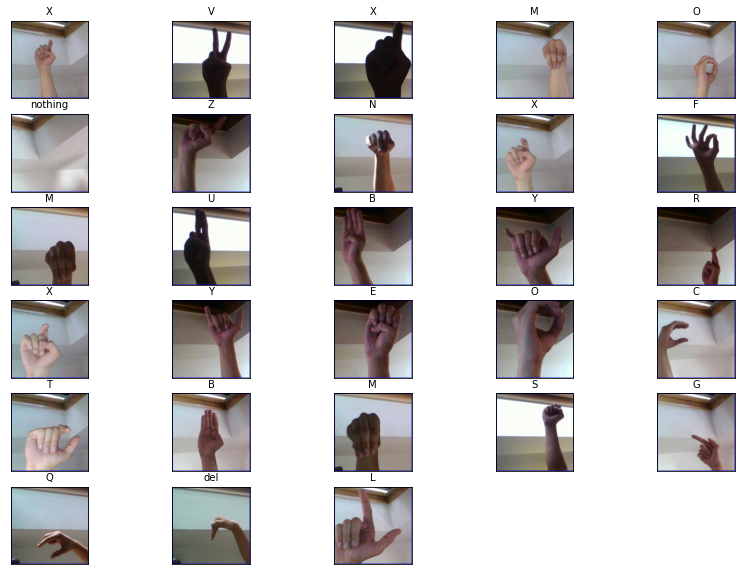

In [14]:
plt.figure(figsize=(14, 10))
for i in range(28):
    idx = np.random.randint(0, len(train_df) - 1)
    plt.subplot(6, 5, i+1)
    img = train_df.iloc[idx, 0]
    plt.imshow(plt.imread(img))
    plt.title(train_df.iloc[idx, 1], size=10, color="black") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

## **DEFINING DATA TRANSFORM**

In [15]:
# Data Transform for VGG 16

data_transform1 = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(brightness=(0.5,1.5),contrast=(1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])



data_transform2 = transforms.Compose([transforms.RandomResizedCrop(299),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(brightness=(0.5,1.5),contrast=(1)),
                                      transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])



## **DEFINING OUR MODEL**

### **1. VGG 16**
### **2. INCEPTION-V3** 

In [16]:
def define_model(model_name, train_dir):

#.............................................................................................................  
  if model_name == "vgg16":

    model = models.vgg16(pretrained=True)


    for param in model.features.parameters(): 
        param.requires_grad = False 


    output_vgg16 = model.classifier[6]


    net = nn.Sequential()
    layers = []
    layers.append(nn.Linear(1000, 256))
    layers.append(nn.ReLU())
    layers.append(nn.Linear(256, 29))
    layers.append(nn.Sigmoid())


    net = nn.Sequential(*layers)

    model_new = nn.Sequential(model, net)

    optimizer = optim.SGD(model_new.parameters(), lr=0.001)

    train_data = datasets.ImageFolder(train_dir, transform=data_transform1)

#.............................................................................................................. 
 

  if model_name == "inception":
    
    model = models.inception_v3(pretrained=True)
  
    for parameter in model.parameters():
      parameter.requires_grad = False

    model.aux_logits = False

    output_inception = model.fc
    net = nn.Sequential()
    layers = []
    layers.append(nn.Linear(1000, 1024))
    layers.append(nn.ReLU())
    layers.append(nn.Linear(1024, 29))
    layers.append(nn.Sigmoid())


    net = nn.Sequential(*layers)

    model_new = nn.Sequential(model, net)
    print(model_new)

    optimizer = torch.optim.RMSprop(filter(lambda p: p.requires_grad, model_new.parameters()), lr=0.001)
    train_data = datasets.ImageFolder(train_dir, transform=data_transform2)

#.........................................................................................................


  # LOSS FUNCTION 

  loss_func = nn.CrossEntropyLoss()

  
  if train_on_gpu:   
        model.cuda()
  

  return model, train_data, loss_func, optimizer



## **TRAINING AND TESTING OF ALL 5 MODELS**

In [17]:
def training_testing(model, loss_func, optimizer, n_epochs, train_data, test_data,  name): 


  train_loss_list = []
  accuracy_list = []

  #Pass data to the dataloader.

  train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=64, shuffle=True) 

  if name == "CNN":
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_dataset))
  

  for epoch in range(1, n_epochs+1):

      train_loss = 0.0
      for batch_i, (data, target) in enumerate(train_loader):
          if train_on_gpu:
              data, target = data.cuda(), target.cuda()
          optimizer.zero_grad()
          output = model(data)
          loss = loss_func(output, target)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()
          
          # print training loss for every batch

          if batch_i % 200 == 199:     
              print('Epoch %d, Batch %d loss: %.16f' %
                    (epoch, batch_i + 1, train_loss / 200))
              train_loss = 0.0

  
      train_loss_list.append(train_loss/200)
      accuracy_list.append(100 - (train_loss/200))
      torch.save(model.state_dict(), './ASL20')

  plt.figure(0) 
  plt.plot(train_loss_list)
  plt.title("Training loss vs epoch")
  plt.xlabel("epoch number")
  plt.ylabel("loss")

  plt.figure(1) 
  plt.plot(accuracy_list)
  plt.title("Training accuracy vs epoch")
  plt.xlabel("epoch number")
  plt.ylabel("Accuracy in %")

#--------------------TESTING-----------------------------

  if name == "CNN":
    correct = 0
    total = 0

    with torch.no_grad():
        model.eval()
        for image, target in test_loader:
            image, target = image.to(device), target.to(device)
            
            output = model(image)
            
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    print('Test Accuracy: %d %%' % (100 * correct / total))
    
  else:
    correct = 0
    model.eval()

    for file in (os.listdir('asl_alphabet_test/asl_alphabet_test/')):

        label = file.strip('_')[0]
        path = os.path.join('asl_alphabet_test/asl_alphabet_test/',file)
        img = Image.open(path)

       
        if  name == "vgg16":
          img_tensor = data_transform1(img).to('cuda').unsqueeze(0)
        if  name == "inception":
          img_tensor = data_transform3(img).to('cuda').unsqueeze(0)

        output = model(img_tensor)
        _, index = torch.max(output, 1)
        index = index.cpu().tolist()
        
        if label == idx_to_class[index[0]]:
            correct += 1
    print('Test Accuracy : ', round(correct/len(os.listdir('asl_alphabet_test/asl_alphabet_test/'))*100, 2), '%')

## **ASL DATA TRANSFORM FOR CNN AND RESNET**

In [18]:
class ASL_DATA_TRANSFORM(torch.utils.data.Dataset):
    def __init__(self, df=train_df, transform=transforms.Compose([transforms.ToTensor()])):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        length = len(self.df)
        return length
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx, 0]
        label = self.df.iloc[idx, 2]
        label = torch.tensor(label)
        image = Image.open(img_path).convert('RGB')
        img = np.array(image)
        image = self.transform(image=img)["image"]
        return image, label


train_transforms = A.Compose([
    A.GaussNoise(),
    A.Blur(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

test_transforms = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])



## **CNN MODEL FROM SCRATCH**

In [24]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc = nn.Sequential(
            nn.Linear(32 * 100 * 100, 81),
            nn.Dropout(0.2),
            nn.BatchNorm1d(81),
            nn.LeakyReLU(81, 29))
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(-1, 32 * 100 * 100)
        x = self.fc(x)
        return x



## **RESNET MODEL FROM SCRATCH**

In [20]:
class ResBottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample):
        super().__init__()
        self.downsample = downsample
        self.conv1 = nn.Conv2d(in_channels, out_channels//4, kernel_size=1, stride=1)
        self.conv2 = nn.Conv2d(out_channels//4, out_channels//4, kernel_size=3, stride=2 if downsample else 1, padding=1)
        self.conv3 = nn.Conv2d(out_channels//4, out_channels, kernel_size=1, stride=1)
        self.shortcut = nn.Sequential()
        
        if self.downsample or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2 if self.downsample else 1),
                nn.BatchNorm2d(out_channels)
            )

        self.bn1 = nn.BatchNorm2d(out_channels//4)
        self.bn2 = nn.BatchNorm2d(out_channels//4)
        self.bn3 = nn.BatchNorm2d(out_channels)

    def forward(self, input):
        shortcut = self.shortcut(input)
        input = nn.ReLU()(self.bn1(self.conv1(input)))
        input = nn.ReLU()(self.bn2(self.conv2(input)))
        input = nn.ReLU()(self.bn3(self.conv3(input)))
        input = input + shortcut
        return nn.ReLU()(input)


class ResNet(nn.Module):
    def __init__(self, in_channels, resblock, repeat, useBottleneck=False, outputs=1000):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        if useBottleneck:
            filters = [64, 256, 512, 1024, 2048]
        else:
            filters = [64, 64, 128, 256, 512]

        self.layer1 = nn.Sequential()
        self.layer1.add_module('conv2_1', resblock(filters[0], filters[1], downsample=False))
        for i in range(1, repeat[0]):
                self.layer1.add_module('conv2_%d'%(i+1,), resblock(filters[1], filters[1], downsample=False))

        self.layer2 = nn.Sequential()
        self.layer2.add_module('conv3_1', resblock(filters[1], filters[2], downsample=True))
        for i in range(1, repeat[1]):
                self.layer2.add_module('conv3_%d' % (i+1,), resblock(filters[2], filters[2], downsample=False))

        self.layer3 = nn.Sequential()
        self.layer3.add_module('conv4_1', resblock(filters[2], filters[3], downsample=True))
        for i in range(1, repeat[2]):
            self.layer3.add_module('conv2_%d' % (i+1,), resblock(filters[3], filters[3], downsample=False))

        self.layer4 = nn.Sequential()
        self.layer4.add_module('conv5_1', resblock(filters[3], filters[4], downsample=True))
        for i in range(1, repeat[3]):
            self.layer4.add_module('conv3_%d'%(i+1,), resblock(filters[4], filters[4], downsample=False))

        self.gap = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = torch.nn.Linear(filters[4], outputs)

    def forward(self, input):
        input = self.layer0(input)
        input = self.layer1(input)
        input = self.layer2(input)
        input = self.layer3(input)
        input = self.layer4(input)
        input = self.gap(input)
        input = torch.flatten(input, start_dim=1)
        input = self.fc(input)

        return input

## **ALEXNET MODEL FROM SCRATCH**

In [21]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 1000),
        )
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [22]:
train_dir = os.path.join(train_folder)

train_dataset = ASL_DATA_TRANSFORM(df=train_df, transform=train_transforms)
test_dataset = ASL_DATA_TRANSFORM(df=test_df_cnn, transform=test_transforms)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## **1. CNN MODEL**

In [ ]:
# CNN Model
model = CNN()
print(model)

# Optimizer Used
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# Loss Function Used
loss_func = nn.CrossEntropyLoss()


model = model.to(device)
loss_func = loss_func.to(device)

#Training and Testing of Model
training_testing(model, loss_func, optimizer, 30, train_dataset,test_dataset,"CNN")

## **2. ResNet MODEL**

In [ ]:
# ResNet Model

model = ResNet(3, ResBottleneckBlock, [3, 4, 6, 3], useBottleneck=True, outputs=1000)
model.to(device)
summary(model, (3, 224, 224))

# Optimizer Used
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# Loss Function Used
loss_func = nn.CrossEntropyLoss()

model = model.to(device)
loss_func = loss_func.to(device)

#Training and Testing of Model
training_testing(model, loss_func, optimizer, 15, train_dataset,test_dataset,"ResNet")

## **3. AlexNet MODEL**

In [ ]:
# AlexNet Model

model = AlexNet()
print(model)

# Optimizer Used
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# Loss Function Used
loss_func = nn.CrossEntropyLoss()

model = model.to(device)
loss_func = loss_func.to(device)

#Training and Testing of Model
training_testing(model, loss_func, optimizer, 15, train_dataset,test_dataset,"AlexNet")

## **4. VGG16 MODEL**

In [ ]:
#Data Transformation + Defining the model

model, train_data,  loss_func, optimizer = define_model("vgg16", train_dir)
idx_to_class = {value:key for key, value in train_data.class_to_idx.items()}

#Training and Testing of Model
training_testing(model, loss_func, optimizer, 15, train_data, test_dataset, "vgg16")


## **5. INCEPTION-v3 MODEL**

In [ ]:
#Data Transformation + Defining the model

model, train_data, loss_func, optimizer = define_model("inception", train_dir)
idx_to_class = {value:key for key, value in train_data.class_to_idx.items()} 

#Training and Testing of Model
training_testing(model, loss_func, optimizer, 16, train_data, test_dataset, "inception")